In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

#membuat function untuk memanggil evaluasi model
def eval_classification(model, pred, xtrain, ytrain, xtest, ytest):
    print("Accuracy (Test Set): %.2f" % accuracy_score(ytest, pred))
    print("Precision (Test Set): %.2f" % precision_score(ytest, pred))
    print("Recall (Test Set): %.2f" % recall_score(ytest, pred))
    print("F1-Score (Test Set): %.2f" % f1_score(ytest, pred))
    
    fpr, tpr, thresholds = roc_curve(ytest, pred, pos_label=1) # pos_label: label yang kita anggap positive
    print("AUC: %.2f" % auc(fpr, tpr))

In [3]:
#import data yang telah dilakukan preprocessing
df = pd.read_csv('marketing_preprocessing.csv')

In [6]:
df.shape

(2189, 29)

# Modeling

## Split Data Train & Test

In [7]:
#Menentukan X dan y
X = df.drop(columns=['Response', 'Dt_Customer'])
y = df['Response']

# Data awal masih imbalance. Akan dilakukan Oversampling dengan SMOTE
from imblearn import under_sampling, over_sampling
X_SMOTE, y_SMOTE = over_sampling.SMOTE(0.8).fit_resample(X, y)

In [8]:
#Memisahkan data menjadi train dan test dengan perbandingan 70:30

from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X_SMOTE, y_SMOTE, test_size = 0.3, random_state = 42)

## Modeling Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

**Prediction Result (in Data Test)**

In [10]:
y_pred = model.predict(X_test)
y_pred

array([1, 0, 1, ..., 0, 0, 0], dtype=int64)

**Evaluation**

In [11]:
eval_classification(model, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.73
Precision (Test Set): 0.72
Recall (Test Set): 0.62
F1-Score (Test Set): 0.67
AUC: 0.72


In [14]:
print('Train score: ' + str(model.score(X_train, y_train))) #accuracy
print('Test score:' + str(model.score(X_test, y_test))) #accuracy

Train score: 0.7614991482112436
Test score:0.7288977159880834


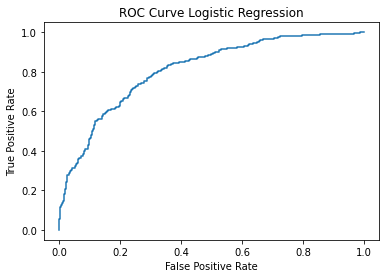

In [15]:
from sklearn import metrics
#define metrics
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve Logistic Regression')
plt.show()

In [16]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# List Hyperparameters yang akan diuji
penalty = ['l2','l1','elasticnet']
C = [0.0001, 0.001, 0.002]
solver = ['liblinear', 'sag', 'saga']
hyperparameters = dict(penalty=penalty, C=C, solver=solver)

# Inisiasi model
logres = LogisticRegression(random_state=42) # Init Logres dengan Gridsearch, cross validation = 5
model = RandomizedSearchCV(logres, hyperparameters, cv=5, random_state=42, scoring='precision')

# Fitting Model & Evaluation
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
eval_classification(model, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.75
Precision (Test Set): 0.74
Recall (Test Set): 0.65
F1-Score (Test Set): 0.69
AUC: 0.74


In [17]:
print('Best algorithm:', model.best_estimator_.get_params()['penalty'])
print('Best C:', model.best_estimator_.get_params()['C'])
print('Best solver:', model.best_estimator_.get_params()['solver'])

Best algorithm: l2
Best C: 0.001
Best solver: liblinear


In [18]:
print('Train score: ' + str(model.score(X_train, y_train))) #accuracy
print('Test score:' + str(model.score(X_test, y_test))) #accuracy

Train score: 0.7768421052631579
Test score:0.735897435897436


OVERFIT

## Modeling K-nearest Neighbor

In [46]:
from sklearn.neighbors import KNeighborsClassifier

model2 = KNeighborsClassifier()
model2.fit(X_train, y_train)

KNeighborsClassifier()

In [47]:
eval_classification(model2, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.89
Precision (Test Set): 0.87
Recall (Test Set): 0.88
F1-Score (Test Set): 0.88
AUC: 0.89


In [48]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.neighbors import KNeighborsClassifier

# List of hyperparameter
n_neighbors = list(range(1,30))
p=[1,2]
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
hyperparameters = dict(n_neighbors=n_neighbors, p=p, algorithm=algorithm)

# Init model
knn = KNeighborsClassifier()
model2 = RandomizedSearchCV(knn, hyperparameters, cv=5, random_state=42, scoring='recall')

# Fit Model & Evaluasi
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)
eval_classification(model2, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.75
Precision (Test Set): 0.69
Recall (Test Set): 0.78
F1-Score (Test Set): 0.74
AUC: 0.76


In [20]:
print('Best n_neighbors:', model2.best_estimator_.get_params()['n_neighbors'])
print('Best p:', model2.best_estimator_.get_params()['p'])
print('Best algorithm:', model2.best_estimator_.get_params()['algorithm'])

Best n_neighbors: 5
Best p: 1
Best algorithm: ball_tree


In [49]:
print('Train score: ' + str(model2.score(X_train, y_train))) #accuracy
print('Test score:' + str(model2.score(X_test, y_test))) #accuracy

Train score: 0.8858230256898192
Test score:0.7840909090909091


OVERFIT

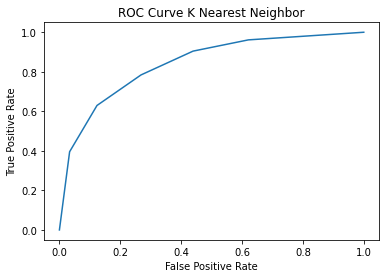

In [22]:
from sklearn import metrics
#define metrics
y_pred_proba2 = model2.predict_proba(X_test)[::,1]
fpr2, tpr2, _ = metrics.roc_curve(y_test,  y_pred_proba2)

#create ROC curve
plt.plot(fpr2,tpr2)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve K Nearest Neighbor')
plt.show()

## Modeling Decision Tree

In [23]:
from sklearn.tree import DecisionTreeClassifier
model3 = DecisionTreeClassifier(random_state=42)
model3.fit(X_train,y_train)

y_pred = model3.predict(X_test)
eval_classification(model3, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.84
Precision (Test Set): 0.81
Recall (Test Set): 0.83
F1-Score (Test Set): 0.82
AUC: 0.84


In [24]:
print('Train score: ' + str(model3.score(X_train, y_train))) #accuracy
print('Test score:' + str(model3.score(X_test, y_test))) #accuracy

Train score: 0.9961669505962522
Test score:0.8421052631578947


OVERFIT

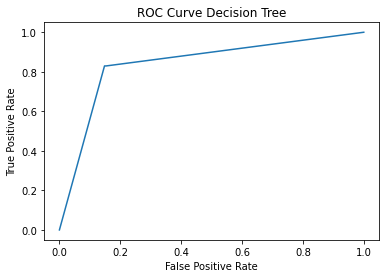

In [25]:
#define metrics
y_pred_proba3 = model3.predict_proba(X_test)[::,1]
fpr3, tpr3, _ = metrics.roc_curve(y_test,  y_pred_proba3)

#create ROC curve
plt.plot(fpr3,tpr3)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve Decision Tree')
plt.show()

In [51]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import numpy as np

# List of hyperparameter
max_depth = [int(x) for x in np.linspace(1, 110, num = 30)]
min_samples_split = [2, 5, 10, 100] 
min_samples_leaf = [1, 2, 4, 10, 20, 50] 
max_features = ['auto', 'sqrt'] 

hyperparameters = dict(max_depth=max_depth, 
                       min_samples_split=min_samples_split, 
                       min_samples_leaf=min_samples_leaf,
                       max_features=max_features
                      )

# Inisialisasi Model
dt = DecisionTreeClassifier(random_state=42)
model3 = RandomizedSearchCV(dt, hyperparameters, cv=5, random_state=42, scoring='recall')
model3.fit(X_train, y_train)

# Predict & Evaluation
y_pred = model3.predict(X_test)#Check performa dari model
eval_classification(model3, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.83
Precision (Test Set): 0.81
Recall (Test Set): 0.80
F1-Score (Test Set): 0.81
AUC: 0.83


In [27]:
print('Best max_depth:', model.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', model.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', model.best_estimator_.get_params()['min_samples_leaf'])
print('Best max_features:', model.best_estimator_.get_params()['max_features'])

Best max_depth: 87
Best min_samples_split: 10
Best min_samples_leaf: 1
Best max_features: sqrt


In [52]:
print('Train score: ' + str(model3.score(X_train, y_train)))
print('Test score:' + str(model3.score(X_test, y_test)))

Train score: 0.9324452901998097
Test score:0.8045454545454546


OVERFIT

## Random Forest

In [37]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train,y_train)

y_pred = rf.predict(X_test)
eval_classification(rf, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.90
Precision (Test Set): 0.88
Recall (Test Set): 0.89
F1-Score (Test Set): 0.89
AUC: 0.90


In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#List Hyperparameters yang akan diuji
hyperparameters = dict(
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)],
    bootstrap = [True],
    criterion = ['entropy'],
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)],
    min_samples_split = [4],
    min_samples_leaf = [1,2],
    max_features = ['auto', 'sqrt', 'log2'],
    n_jobs = [-1],
        )

# Init
rf = RandomForestClassifier(random_state=42)
rf_tuned = RandomizedSearchCV(rf, hyperparameters, cv=5, random_state=42, scoring='recall')
rf_tuned.fit(X_train,y_train)

# Predict & Evaluation
y_pred = rf_tuned.predict(X_test)
eval_classification(rf_tuned, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.90
Precision (Test Set): 0.89
Recall (Test Set): 0.89
F1-Score (Test Set): 0.89
AUC: 0.90


In [55]:
print('Train score: ' + str(rf_tuned.score(X_train, y_train)))
print('Test score:' + str(rf_tuned.score(X_test, y_test)))

Train score: 0.9952426260704091
Test score:0.8886363636363637


OVERFIT

In [39]:
def show_best_hyperparameter(model, hyperparameters):
    for key, value in hyperparameters.items() :
        print('Best '+key+':', model.get_params()[key])
        
show_best_hyperparameter(rf_tuned.best_estimator_, hyperparameters)

Best n_estimators: 300
Best bootstrap: True
Best criterion: entropy
Best max_depth: 20
Best min_samples_split: 5
Best min_samples_leaf: 1
Best max_features: sqrt
Best n_jobs: -1


## XGBoost

In [43]:
from xgboost import XGBClassifier
xg = XGBClassifier(random_state=42)
xg.fit(X_train, y_train)

y_pred = xg.predict(X_test)
eval_classification(xg, y_pred, X_train, y_train, X_test, y_test)

[18:33:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy (Test Set): 0.91
Precision (Test Set): 0.89
Recall (Test Set): 0.90
F1-Score (Test Set): 0.89
AUC: 0.91


In [44]:
#Menjadikan ke dalam bentuk dictionary
hyperparameters = {
                    'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
                    'min_child_weight' : [int(x) for x in np.linspace(1, 20, num = 11)],
                    'gamma' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'tree_method' : ['auto', 'exact', 'approx', 'hist'],

                    'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'eta' : [float(x) for x in np.linspace(0, 1, num = 100)],

                    'lambda' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'alpha' : [float(x) for x in np.linspace(0, 1, num = 11)]
                    }

# Init
xg = XGBClassifier(random_state=42)
xg_tuned = RandomizedSearchCV(xg, hyperparameters, cv=5, random_state=42, scoring='recall')
xg_tuned.fit(X_train,y_train)

# Predict & Evaluation
y_pred = xg_tuned.predict(X_test)#Check performa dari model
eval_classification(xg_tuned, y_pred, X_train, y_train, X_test, y_test)

[18:34:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:34:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:34:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:34:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [36]:
print('Train score: ' + str(xg_tuned.score(X_train, y_train)))
print('Test score:' + str(xg_tuned.score(X_test, y_test)))

Train score: 0.9933396764985728
Test score:0.884090909090909


Berdasarkan model yang telah dilakukan di atas, model dengan hasil yang paling baik berdasarkan evaluasi modeling nya adalah RandomForest. Namun hampir pada semua jenis modeling yang dilakukan, hasilnya masih overfitting (test score lebih rendah daripada train score). Sehingga sepertinya perlu dilakukan iterasi modeling setelah melakukan feature selection setelah memperhatikan feature importance

# Feature Importance

In [32]:
def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

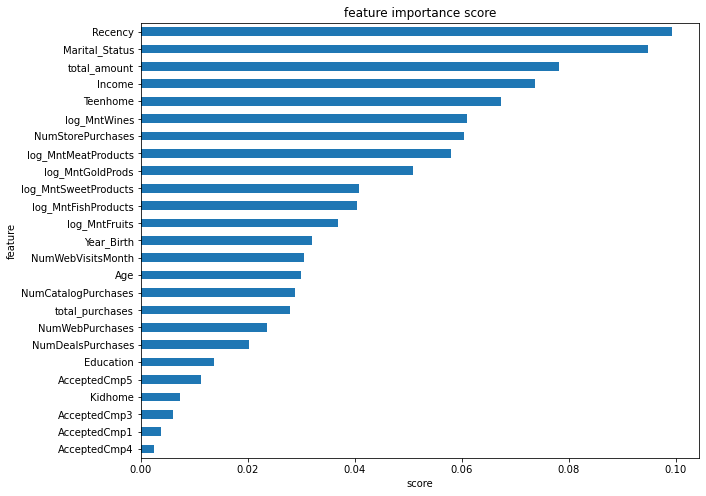

In [42]:
#menampilkan feature importance score berdasarkan model Random Forest
show_feature_importance(rf_tuned.best_estimator_)

Dari barplot di atas menunjukkan bahwa 4 feature yang paling mempengaruhi model adalah `Recency`, `Marital_Status`, `total_amount`, dan `Income`. Keempat feature ini perlu dipertahankan untuk mendapatkan model yang baik. Sementara itu feature `AcceptedCmp` tidak terlalu mempengaruhi model